# Project Overview
This project aims to build a convolutional neural network that can classify images of coffee beans into one of four categories representing various stages of the roasting process: raw, light, medium, and dark. The model will take jpeg images of coffee beans as an input, analyze the image using convolutional layers, and make a prediction about the roast stage.

This project is important to pursue because it demonstrates how artificial intelligence (AI) can be used to improve processes and outcomes in the coffee industry. By leveraging the power of machine learning, coffee roasters can achieve greater consistency in their roasts, which can lead to higher quality coffee and increased customer satisfaction. Additionally, this project is just the tip of the iceberg when it comes to the potential for innovation in the coffee industry utilizing AI technology. There are many other applications of machine learning in the coffee industry, such as predicting consumer preferences, optimizing supply chain logistics, and improving the efficiency of coffee farming. As such, this project represents an exciting opportunity to explore the possibilities of AI in the coffee industry and beyond.  

The project can be broken down into the following steps:  
- Collect a dataset of labeled images of coffee beans in the four roast level categories.    
- Preprocess the images (resize, crop, normalize, etc.) to make them suitable for training the model.  
- Iterate over various versions of network architecture, hyperparameters and training protocols.   
- Evaluate the performance of each model version on a test dataset to determine accuracy and other key performance indicators (KPI)  
- Deploy the model to a system that can accept jpeg images as input, classify them, and alert workers when the desired roast is achieved. 

# Business Use Case

This project has the potential to significantly improve the coffee roasting process in terms of quality control, labor efficiency, and profitability. By using a camera positioned above the roasting bin to periodically capture images and analyze the roast level of the beans, the system can help coffee roasters achieve greater consistency in their roasts. This can lead to higher quality coffee and increased customer satisfaction.  

In addition, this system can help reduce waste by alerting workers when the beans are overcooked or undercooked, thereby minimizing the amount of coffee that must be discarded. This reduction in waste can have a significant impact on a roaster's bottom line, as it reduces the cost of materials and increases profitability.  

Furthermore, this system can help workers be more productive by allowing them to focus on other tasks while the roasting process is underway. Since the system can monitor the roasting process and alert workers when the desired roast level is achieved, workers do not need to pay as close attention to each roasting bin. This can free up time and resources that can be directed towards other areas of the business, further increasing efficiency and profitability.
Overall, this project represents a powerful tool for coffee roasters looking to improve their operations and achieve greater success in the highly competitive coffee industry. By utilizing AI technology to improve quality control, reduce waste, and increase labor efficiency, coffee roasters can deliver a better product to their customers and increase their bottom line.

# Data Understanding  
The dataset used in this project comes from kaggle.com and consists of 1200 training images and 400 test images. Each sample is equally distributed between the four classes, with 300 images per class in the training set and 100 images per class in the test set. All the images are of a single coffee bean and are of size 224x224 pixels. The dataset's class labels are (Dark, 0), (Green, 1), (Light, 2), and (Medium, 3). The images were captured using an iPhone 12 mini, which means that the images are of high quality and consistent.
To further test the model and the dataset's limitations, I will also create a small validation dataset using our own iPhone 13 pro camera. This dataset will include images of both single coffee beans, like the training and test data, as well as images of multiple beans. By doing so, I hope to evaluate the model's performance in detecting the stage of the roasting process of both individual and multiple beans.
Overall, I believe that this dataset provides a good representation of the different stages of coffee bean roasting, and I am confident that our model can successfully classify coffee bean images.


In [43]:
# dependencies for data preprocessing
import os
from keras.preprocessing.image import ImageDataGenerator

# dependencies for model compilation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

from keras import layers
from keras import models
from keras import optimizers
from keras.metrics import Recall
from keras.regularizers import l2

from keras.callbacks import ModelCheckpoint, EarlyStopping

# dependencies for model diagnostics
from sklearn.metrics import confusion_matrix, classification_report
import project_toolkit as ptk

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import numpy as np
import pandas as pd

In [11]:
# file paths to data directories
train_dir = "data/train/"
test_dir = "data/test/"

In [12]:

# dictionary of volume of data per class per sample
# len(os.listdir(train_dir+"Dark"))
class_balance_dict = {
    "Train Sample":[len(os.listdir(train_dir+"A. Green")),
                    len(os.listdir(train_dir+"B. Light")),
                    len(os.listdir(train_dir+"C. Medium")),
                    len(os.listdir(train_dir+"D. Dark"))],
    "Test Sample":[len(os.listdir(test_dir+"A. Green")),
                   len(os.listdir(test_dir+"B. Light")),
                   len(os.listdir(test_dir+"C. Medium")),
                   len(os.listdir(test_dir+"D. Dark"))]
                    }

# # class balance dictionary as a dataframe with row index representing class and column index representing sample
class_balance_df = pd.DataFrame(class_balance_dict,index=['Green','Light','Medium','Dark'])
class_balance_df

,Train Sample,Test Sample
Green,300,100
Light,300,100
Medium,300,100
Dark,300,100


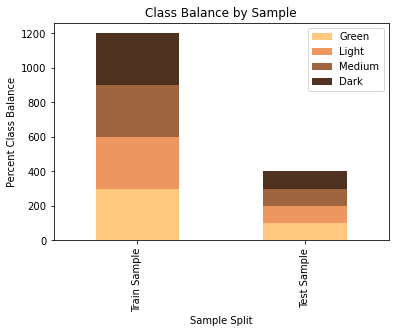

In [13]:
# Create colors
cmap = plt.cm.copper
color_indexes = [cmap(1.0), cmap(0.75), cmap(0.5), cmap(0.25)]

# create stacked bar chart for students DataFrame
class_balance_df.T.plot(kind='bar', stacked=True, color=color_indexes)

# Add Title and Labels
plt.title('Class Balance by Sample')
plt.xlabel('Sample Split')
plt.ylabel('Percent Class Balance')

plt.legend(bbox_to_anchor=(1, 1))

plt.show()

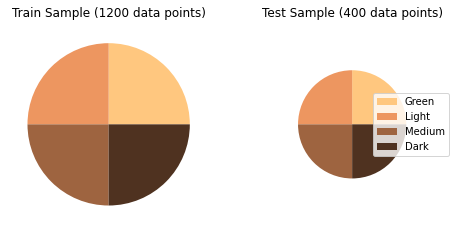

In [14]:
# Define the figure and subplot layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
pie_colors = [cmap(1.0), cmap(0.75), cmap(0.5), cmap(0.25)]

# Set the radius of the first pie chart
radius1 = 1

# Create the first pie chart
wedges1, texts1 = ax1.pie(class_balance_df['Train Sample'], radius=radius1,colors=pie_colors)

# Set the radius of the second pie chart
radius2 = radius1 * 2 / 3

# Create the second pie chart
wedges2, texts2 = ax2.pie(class_balance_df['Test Sample'], radius=radius2,colors=pie_colors)

# Add a legend to the second pie chart
ax2.legend(wedges2, ['Green','Light','Medium','Dark'], loc="right")

# Set the title for each subplot
ax1.set_title("Train Sample (1200 data points)")
ax2.set_title("Test Sample (400 data points)")

# Show the plot
plt.show()

# Data Preparation
To prepare the image data for modeling, I utilized the ImageDataGenerator class from Keras to read in the JPEG files and directly access the image data as matrices. This method makes it easy to load in and preprocess large datasets. The ImageDataGenerator objects were set to normalize the pixel values to a scale of 0-1 using the rescale argument. I also set the color_mode argument to grayscale since I only need to work with a single channel for these images.

Normalizing the pixel values and setting to grayscale are standard practices for image classification tasks. Normalizing the pixel values scales down the pixel values to a range that is better suited for machine learning algorithms, while setting the images to grayscale removes color as a variable in the analysis, simplifying the model's learning process.

In [15]:
# instatiating a data degenerater for each split sample 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
# 25 is a common factor or both 1200 and 400
batch_size = 25

In [17]:
train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(224,224),
                       batch_size= batch_size,
                       class_mode='categorical',
                       color_mode='grayscale')

test_data_generator = test_datagen.flow_from_directory(
                      test_dir,
                      target_size=(224,224),
                      batch_size= batch_size,
                      class_mode='categorical',
                      color_mode='grayscale')

Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


# Modeling Methods

## Baseline Model

The baseline model consists of three convolutional layers separated by three max pooling layers, a flattening layer, and then two Dense layers and then another Dense output layer. The model is compiled using the Adam gradient descent optimizer and its loss is measured based on categorical cross entropy. The filter count and kernal size for each layer has been optimized for performance as well as training speed, and are set in a way that the filters' areas of observation do not overlap. The model is trained over a single epoch in 48 training steps and 16 validation steps in batches of 25, so each data point, both training and test, are observed only once throughout training.  

The base model has an overall accuracy of about 75%, and it appears to be more dependable the darker the bean is. The loss is in a desirable range, so I hesitate to say there is overfitting or a strong bias at play here, I believe its more likely that a lack of image contrast in the lighter beans provides less information for the model to digest. 


In [10]:
# Building the model
base_model = Sequential()

# 3 convolutional layers
base_model.add(Conv2D(56, (4,4), activation='relu', input_shape = (224,224,1)))
base_model.add(MaxPooling2D(pool_size=(2,2)))

base_model.add(Conv2D(112, (2,2), activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2,2)))

base_model.add(Conv2D(112, (2,2), activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2,2)))

base_model.add(Flatten())

base_model.add(Dense(56,activation='relu'))
base_model.add(Dense(56, activation='relu'))

base_model.add(Dense(4))
base_model.add(Activation("softmax"))

# Compiling the base_model using some basic parameters
base_model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [11]:
base_model_results = base_model.fit(
                     train_data_generator,
                     batch_size=batch_size,
                     epochs=1,
                     steps_per_epoch=48,
                     validation_data=test_data_generator,
                     validation_batch_size=batch_size,
                     validation_steps=16
                     )

48/48 [==============================] - 62s 1s/step - loss: 1.1284 - accuracy: 0.4308 - val_loss: 0.5607 - val_accuracy: 0.7275


In [13]:
base_KPI, base_report, base_matrix, base_labels = ptk.evaluate_model(base_model,test_data_generator)

13/13 [==============================] - 5s 384ms/step - loss: 0.5607 - accuracy: 0.7275
Done!


In [14]:
print(base_report)

              precision    recall  f1-score   support

           0       0.70      0.98      0.82       100
           1       0.88      0.49      0.63       100
           2       0.86      0.44      0.58       100
           3       0.67      0.96      0.79       100

   micro avg       0.73      0.72      0.73       400
   macro avg       0.78      0.72      0.70       400
weighted avg       0.78      0.72      0.70       400
 samples avg       0.72      0.72      0.72       400



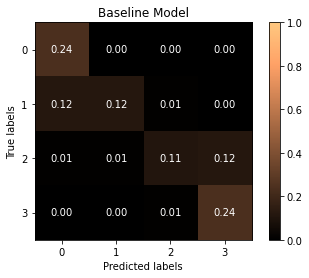

In [15]:
ptk.viz_confusion_matrix(base_matrix,'Baseline Model')

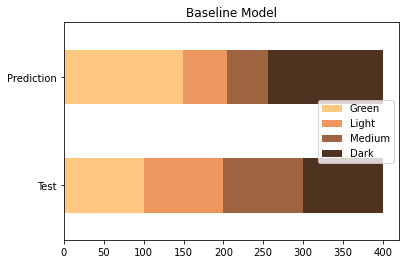

,Test,Prediction
Green,100,149
Light,100,56
Medium,100,51
Dark,100,144


In [25]:
ptk.viz_class_balance_comparison(base_labels,"Baseline Model")

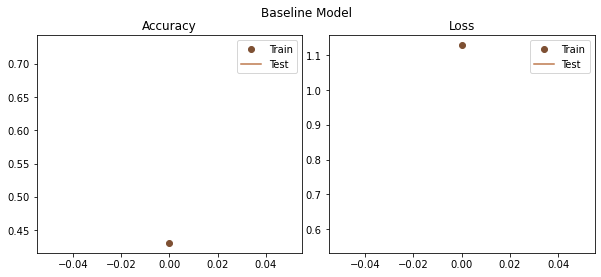

In [17]:
ptk.viz_training_history(base_model_results,'Baseline Model')

## Optimizing the Fit Function

In [85]:
# define early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

In [86]:
# Building the model
fit_model = Sequential()

# 3 convolutional layers
fit_model.add(Conv2D(56, (4,4), activation='relu', input_shape = (224,224,1)))
fit_model.add(MaxPooling2D(pool_size=(2,2)))

fit_model.add(Conv2D(112, (2,2), activation='relu'))
fit_model.add(MaxPooling2D(pool_size=(2,2)))

fit_model.add(Conv2D(112, (2,2), activation='relu'))
fit_model.add(MaxPooling2D(pool_size=(2,2)))

fit_model.add(Flatten())

fit_model.add(Dense(56,activation='relu'))
fit_model.add(Dense(56, activation='relu'))

fit_model.add(Dense(4))
fit_model.add(Activation("softmax"))

# Compiling the fit_model using some basic parameters
fit_model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [87]:
fit_model_results = fit_model.fit(
                     train_data_generator,
                     batch_size=batch_size,
                     epochs=100,
                     steps_per_epoch=48,
                     validation_data=test_data_generator,
                     validation_batch_size=batch_size,
                     validation_steps=2,
                     callbacks=[early_stop]
                     )

Epoch 1/100
48/48 [==============================] - 105s 2s/step - loss: 1.0568 - accuracy: 0.4458 - val_loss: 0.5919 - val_accuracy: 0.7200
Epoch 2/100
48/48 [==============================] - 108s 2s/step - loss: 0.5959 - accuracy: 0.7358 - val_loss: 0.4742 - val_accuracy: 0.8000
Epoch 3/100
48/48 [==============================] - 98s 2s/step - loss: 0.4682 - accuracy: 0.8058 - val_loss: 1.5657 - val_accuracy: 0.4800
Epoch 4/100
48/48 [==============================] - 97s 2s/step - loss: 0.5042 - accuracy: 0.7917 - val_loss: 0.3506 - val_accuracy: 0.8400
Epoch 5/100
48/48 [==============================] - 97s 2s/step - loss: 0.3559 - accuracy: 0.8483 - val_loss: 0.3007 - val_accuracy: 0.9000
Epoch 6/100
48/48 [==============================] - 96s 2s/step - loss: 0.2544 - accuracy: 0.8875 - val_loss: 0.0996 - val_accuracy: 0.9400
Epoch 7/100
48/48 [==============================] - 97s 2s/step - loss: 0.2416 - accuracy: 0.9150 - val_loss: 0.2859 - val_accuracy: 0.9200
Epoch 8/100

In [88]:
fit_KPI, fit_report, fit_matrix, fit_labels = ptk.evaluate_model(fit_model,test_data_generator)

13/13 [==============================] - 4s 329ms/step - loss: 0.0132 - accuracy: 0.9975
Done!


In [89]:
print(fit_report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.99      0.99       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100

   micro avg       1.00      1.00      1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400
 samples avg       1.00      1.00      1.00       400



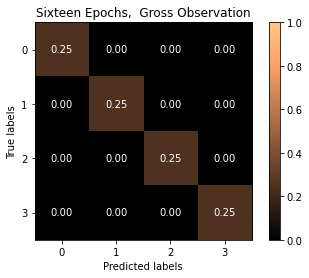

In [91]:
ptk.viz_confusion_matrix(fit_matrix,"Sixteen Epochs,  Gross Observation")

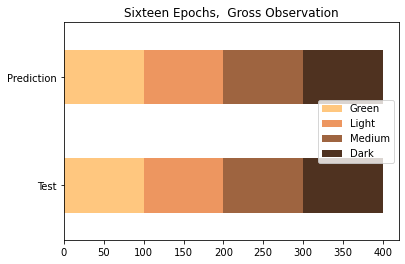

,Test,Prediction
Green,100,101
Light,100,99
Medium,100,100
Dark,100,100


In [94]:
ptk.viz_class_balance_comparison(fit_labels, "Sixteen Epochs,  Gross Observation")

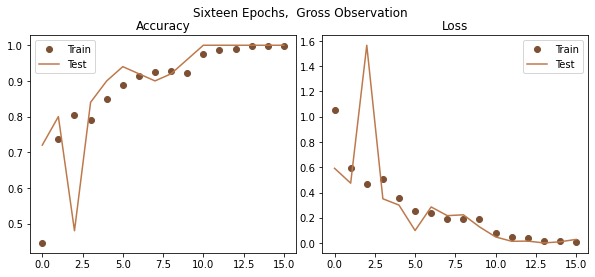

In [95]:
ptk.viz_training_history(fit_model_results,"Sixteen Epochs,  Gross Observation")

## Network Regularization

In [34]:
# Building the model
L2_model = Sequential()

# 3 convolutional layers
L2_model.add(Conv2D(56, (4,4), activation='relu', input_shape = (224,224,1)))
L2_model.add(MaxPooling2D(pool_size=(2,2)))

L2_model.add(Conv2D(112, (2,2), activation='relu'))
L2_model.add(MaxPooling2D(pool_size=(2,2)))

L2_model.add(Conv2D(112, (2,2), activation='relu'))
L2_model.add(MaxPooling2D(pool_size=(2,2)))

L2_model.add(Flatten())

L2_model.add(Dense(56,activation='relu',kernel_regularizer=l2(0.00005)))
L2_model.add(Dense(56, activation='relu',kernel_regularizer=l2(0.0005)))

L2_model.add(Dense(4))
L2_model.add(Activation("softmax"))

# Compiling the L2_model using some basic parameters
L2_model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [36]:
L2_model_results = L2_model.fit(
                     train_data_generator,
                     batch_size=batch_size,
                     epochs=15,
                     steps_per_epoch=48,
                     validation_data=test_data_generator,
                     validation_batch_size=batch_size,
                     validation_steps=2
                     )

Epoch 1/15
48/48 [==============================] - 99s 2s/step - loss: 0.9208 - accuracy: 0.5850 - val_loss: 0.5371 - val_accuracy: 0.7600
Epoch 2/15
48/48 [==============================] - 97s 2s/step - loss: 0.6016 - accuracy: 0.7342 - val_loss: 0.4391 - val_accuracy: 0.8000
Epoch 3/15
48/48 [==============================] - 130s 3s/step - loss: 0.5381 - accuracy: 0.7683 - val_loss: 0.4154 - val_accuracy: 0.7800
Epoch 4/15
48/48 [==============================] - 125s 3s/step - loss: 0.4301 - accuracy: 0.8258 - val_loss: 0.4976 - val_accuracy: 0.7800
Epoch 5/15
48/48 [==============================] - 145s 3s/step - loss: 0.3786 - accuracy: 0.8350 - val_loss: 0.2960 - val_accuracy: 0.9200
Epoch 6/15
48/48 [==============================] - 126s 3s/step - loss: 0.2811 - accuracy: 0.8858 - val_loss: 0.1484 - val_accuracy: 0.9600
Epoch 7/15
48/48 [==============================] - 105s 2s/step - loss: 0.2671 - accuracy: 0.8992 - val_loss: 0.1508 - val_accuracy: 0.9800
Epoch 8/15
48/4

In [37]:
L2_KPI, L2_report, L2_matrix, L2_labels = ptk.evaluate_model(L2_model,test_data_generator)

13/13 [==============================] - 4s 325ms/step - loss: 0.0406 - accuracy: 0.9950
Done!


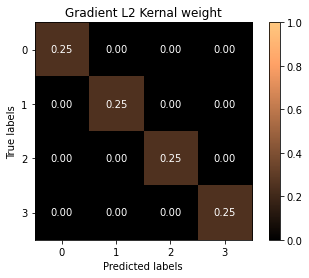

In [38]:
ptk.viz_confusion_matrix(L2_matrix,"Gradient L2 Kernal weight")

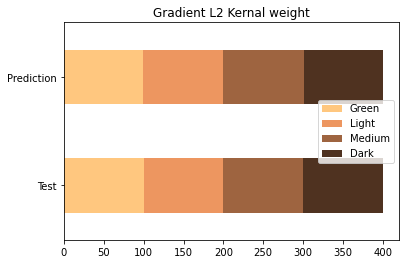

,Test,Prediction
Green,100,99
Light,100,101
Medium,100,101
Dark,100,99


In [39]:
ptk.viz_class_balance_comparison(L2_labels,"Gradient L2 Kernal weight")

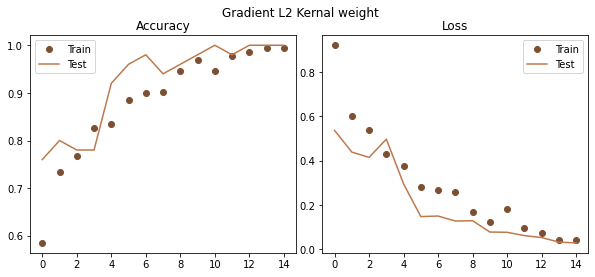

In [40]:
ptk.viz_training_history(L2_model_results,"Gradient L2 Kernal weight")

## Exporting Model

In [56]:
# Building the model
final_model = Sequential()

# 3 convolutional layers
final_model.add(Conv2D(56, (4,4), activation='relu', input_shape = (224,224,1)))
final_model.add(MaxPooling2D(pool_size=(2,2)))

final_model.add(Conv2D(112, (2,2), activation='relu'))
final_model.add(MaxPooling2D(pool_size=(2,2)))

final_model.add(Conv2D(112, (2,2), activation='relu'))
final_model.add(MaxPooling2D(pool_size=(2,2)))

final_model.add(Flatten())

final_model.add(Dense(56,activation='relu',kernel_regularizer=l2(0.00005)))
final_model.add(Dense(56, activation='relu',kernel_regularizer=l2(0.0005)))

final_model.add(Dense(4))
final_model.add(Activation("softmax"))

# Compiling the final_model using some basic parameters
final_model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [57]:
final_callback = [
              ModelCheckpoint(filepath='data/final_model.h5',monitor='val_accuracy',save_best_only=True),
              EarlyStopping(monitor='val_accuracy', patience=5)
              ]

In [58]:
final_model_results = final_model.fit(train_data_generator,
                                        callbacks=final_callback,
                                        batch_size=batch_size,
                                        steps_per_epoch=48, 
                                        epochs=50, 
                                        validation_data=test_data_generator, 
                                        validation_steps=2
                                        )

Epoch 1/50
48/48 [==============================] - 64s 1s/step - loss: 1.1693 - accuracy: 0.4225 - val_loss: 0.7403 - val_accuracy: 0.5600
Epoch 2/50
48/48 [==============================] - 93s 2s/step - loss: 0.6256 - accuracy: 0.6917 - val_loss: 0.4824 - val_accuracy: 0.7600
Epoch 3/50
48/48 [==============================] - 68s 1s/step - loss: 0.6281 - accuracy: 0.7158 - val_loss: 0.4483 - val_accuracy: 0.8400
Epoch 4/50
48/48 [==============================] - 75s 2s/step - loss: 0.4389 - accuracy: 0.8225 - val_loss: 0.3818 - val_accuracy: 0.8400
Epoch 5/50
48/48 [==============================] - 97s 2s/step - loss: 0.3971 - accuracy: 0.8275 - val_loss: 0.2197 - val_accuracy: 0.9200
Epoch 6/50
48/48 [==============================] - 88s 2s/step - loss: 0.3157 - accuracy: 0.8833 - val_loss: 0.3546 - val_accuracy: 0.8600
Epoch 7/50
48/48 [==============================] - 89s 2s/step - loss: 0.3360 - accuracy: 0.8675 - val_loss: 0.2039 - val_accuracy: 0.9400
Epoch 8/50
48/48 [==

In [59]:
final_KPI, final_report, final_matrix, final_labels = ptk.evaluate_model(final_model,test_data_generator)

13/13 [==============================] - 9s 693ms/step - loss: 0.0247 - accuracy: 1.0000
Done!


In [60]:
print(final_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100

   micro avg       1.00      1.00      1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400
 samples avg       1.00      1.00      1.00       400



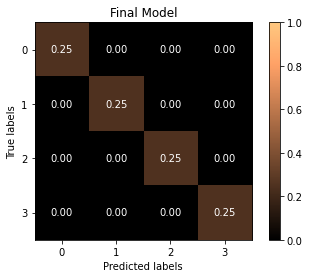

In [61]:
ptk.viz_confusion_matrix(final_matrix, "Final Model")

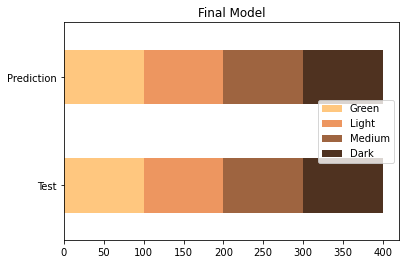

,Test,Prediction
Green,100,100
Light,100,100
Medium,100,100
Dark,100,100


In [62]:
ptk.viz_class_balance_comparison(final_labels,"Final Model")

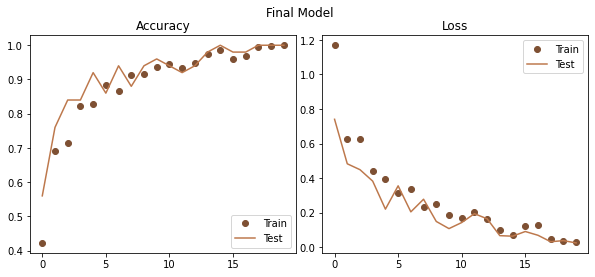

In [63]:
ptk.viz_training_history(final_model_results, "Final Model")

# Proof of Concept

In [82]:
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import os

In [ ]:
saved_model =  load_model('data/final_model.h5')

In [65]:
results_train = saved_model.evaluate(train_data_generator)
print(f'Training Accuracy: {results_train[1]:.3}\nTraining Loss: {results_train[0]:.3}')

print('----------')

results_test = saved_model.evaluate(test_data_generator)
print(f'Test Accuracy: {results_test[1]:.3}\nTest Loss: {results_test[0]:.3}')


48/48 [==============================] - 16s 330ms/step - loss: 0.0724 - accuracy: 0.9867
Training Accuracy: 0.987
Training Loss: 0.0724
----------
16/16 [==============================] - 6s 390ms/step - loss: 0.0642 - accuracy: 0.9900
Test Accuracy: 0.99
Test Loss: 0.0642


In [81]:


# Load image and resize to model input shape
img = load_img("data/test/A. Green/green (7).png", target_size=(224, 224))

# Convert image data to numpy array
img_array = img_to_array(img)

# Convert the image to grayscale
img_array = np.dot(img_array, [0.2989, 0.5870, 0.1140])

# Normalize the image array
img_array /= 255.0

# Expand dimensions to match the input shape of the model
input_array = np.expand_dims(img_array, axis=0)
input_array = np.expand_dims(input_array, axis=-1)

# Make predictions
predictions = saved_model.predict(input_array)
predicted_label = np.argmax(predictions)

label_dict = {0:"Green",1:"Light",2:"Medium",3:"Dark"}

print("Predicted label:", label_dict[predicted_label])


Predicted label: Green


In [91]:
def classify_bean(filepath:str):
    """
    Classifies the roast level of a coffee bean image.

    Args:
        filepath (str): The file path of the coffee bean image to classify.

    Returns:
         string: the predicted label as a string: "Green", "Light", "Medium" or "Dark".

    Raises:
        ValueError: If the input image is not a valid file or if the input image shape is not 224x224.
    """

    if not os.path.isfile(filepath):
        print("Error: {} is not a valid file path.".format(filepath))
        return

    else:
        # Load image and resize to model input shape
        img = load_img(filepath, target_size=(224, 224))

        # Convert image data to numpy array
        img_array = img_to_array(img)

        # Convert the image to grayscale
        img_array = np.dot(img_array, [0.2989, 0.5870, 0.1140])

        # Normalize the image array
        img_array /= 255.0

        # Expand dimensions to match the input shape of the model
        input_array = np.expand_dims(img_array, axis=0)
        input_array = np.expand_dims(input_array, axis=-1)

        # Make predictions
        predictions = saved_model.predict(input_array)
        predicted_label = np.argmax(predictions)

        label_dict = {0:"Green",1:"Light",2:"Medium",3:"Dark"}

        print("Predicted label:", label_dict[predicted_label])

        # return predicted_label


In [92]:
classify_bean("data/test/C. Medium/medium (13).png")

Predicted label: Medium


In [94]:
help(ptk.viz_confusion_matrix)

Help on function viz_confusion_matrix in module project_toolkit:

viz_confusion_matrix(confusion_matrix_array: <built-in function array>, title: str)
    Takes in a numpy array (must be 2D, with only 4 elements (i.e. a confusion matrix))
    normalizes each element in the array to be a percentage 
    plots the normalized values as a confusion matrix using matplotlib
    returns no values, uses .show() method to dispaly the figure

